In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
results_path: str = '../../benchmark_results/results.csv'
df_results = pd.read_csv(results_path)
axis_to_keep: list = ['Unnamed: 0','imagegame, % Played', 'imagegame, Quality Score', 'privateshared, % Played', 'privateshared, Quality Score', 'referencegame, % Played', 'referencegame, Quality Score', 'taboo, % Played', 'taboo, Quality Score', 'wordle, % Played', 'wordle, Quality Score', 'wordle_withclue, % Played', 'wordle_withclue, Quality Score', 'wordle_withcritic, % Played', 'wordle_withcritic, Quality Score',]

columns_played = [a for a in axis_to_keep if '%' in a or a == 'Unnamed: 0']
columns_quality = [a for a in axis_to_keep if '%' not in a]
assert len(columns_played) == len(columns_quality)

In [3]:
df_played = df_results[columns_played]
df_quality = df_results[columns_quality]

In [4]:
df_quality.columns

Index(['Unnamed: 0', 'imagegame, Quality Score',
       'privateshared, Quality Score', 'referencegame, Quality Score',
       'taboo, Quality Score', 'wordle, Quality Score',
       'wordle_withclue, Quality Score', 'wordle_withcritic, Quality Score'],
      dtype='object')

['imagegame, % Played', 'privateshared, % Played', 'referencegame, % Played', 'taboo, % Played', 'wordle, % Played', 'wordle_withclue, % Played', 'wordle_withcritic, % Played']


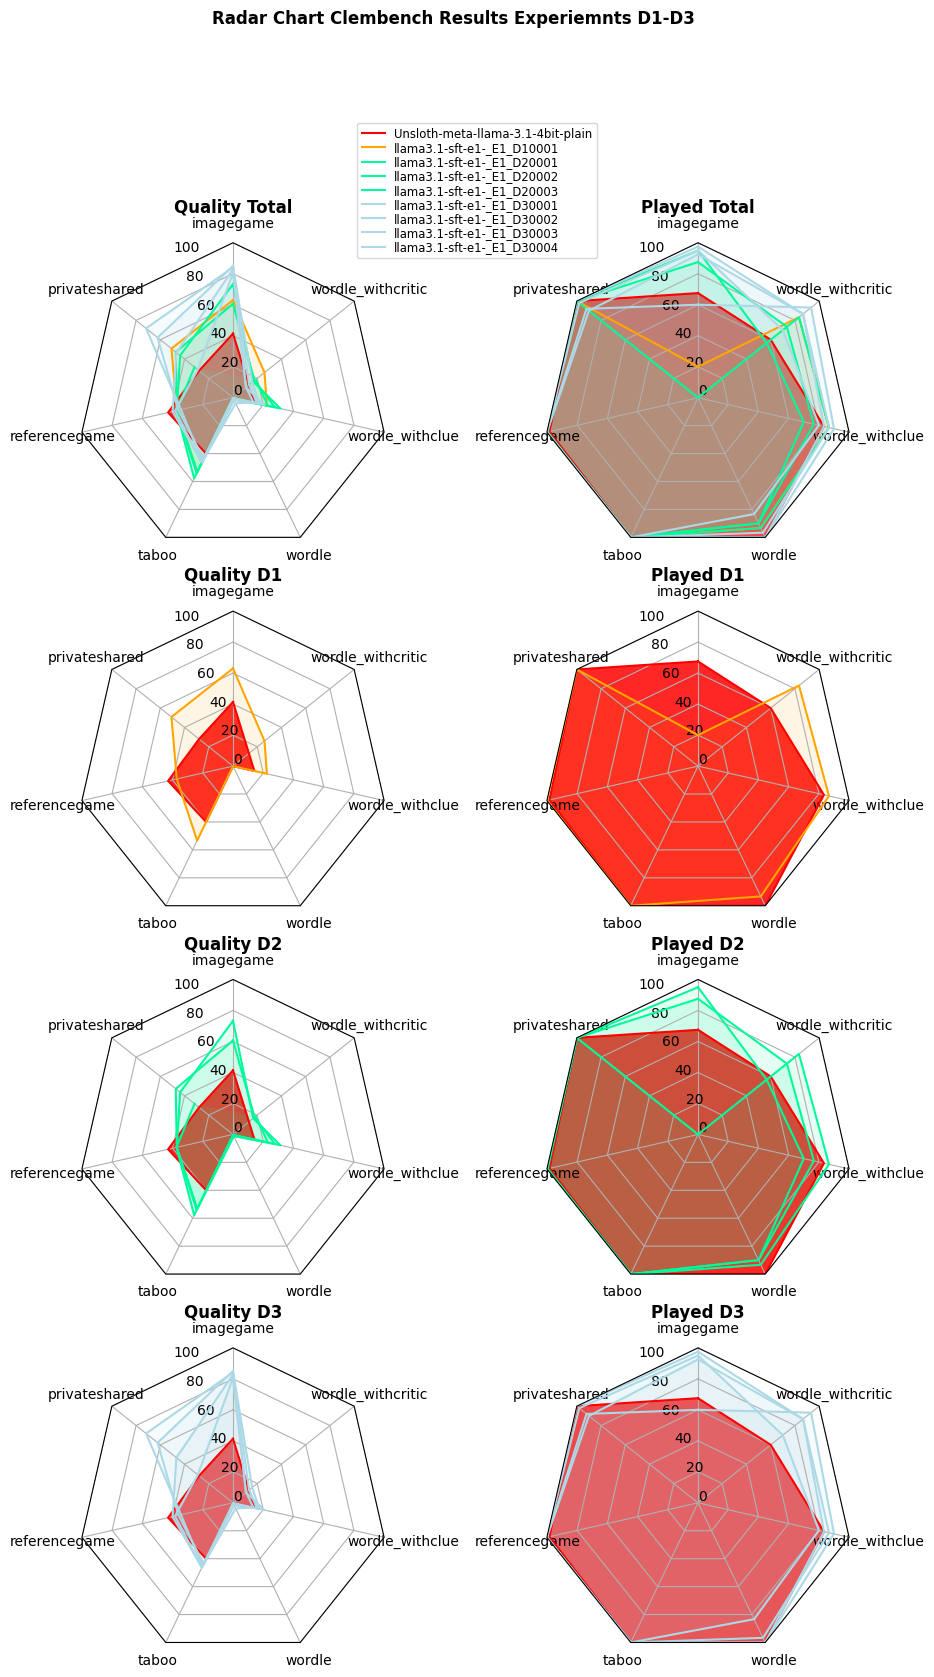

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data(data_quality: pd.DataFrame, data_played: pd.DataFrame):
    df_exp_d1_played = df_played[df_played['Unnamed: 0'].str.contains('D1') | df_played['Unnamed: 0'].str.contains('plain')].drop(columns=['Unnamed: 0'])
    df_exp_d1_quality = data_quality[data_quality['Unnamed: 0'].str.contains('D1') | data_quality['Unnamed: 0'].str.contains('plain')].drop(columns=['Unnamed: 0'])

    df_exp_d2_played = df_played[df_played['Unnamed: 0'].str.contains('D2') | df_played['Unnamed: 0'].str.contains('plain')].drop(columns=['Unnamed: 0'])
    df_exp_d2_quality = data_quality[data_quality['Unnamed: 0'].str.contains('D2') | data_quality['Unnamed: 0'].str.contains('plain')].drop(columns=['Unnamed: 0'])

    df_exp_d3_played = df_played[df_played['Unnamed: 0'].str.contains('D3') | df_played['Unnamed: 0'].str.contains('plain')].drop(columns=['Unnamed: 0'])
    df_exp_d3_quality = data_quality[data_quality['Unnamed: 0'].str.contains('D3') | data_quality['Unnamed: 0'].str.contains('plain')].drop(columns=['Unnamed: 0'])

    df_played_total = data_played.drop(columns=['Unnamed: 0'])
    df_quality_total = data_quality.drop(columns=['Unnamed: 0'])
    
    labels: list = list(df_played_total.columns)
    print(labels)
    data = [
        [l.split(",")[0] for l in labels],
        ('Quality Total', df_quality_total.to_numpy()),
        ('Played Total', df_played_total.to_numpy()),
        ('Quality D1', df_exp_d1_quality.to_numpy()),
        ('Played D1', df_exp_d1_played.to_numpy()),
        ('Quality D2', df_exp_d2_quality.to_numpy()),
        ('Played D2', df_exp_d2_played.to_numpy()),
        ('Quality D3', df_exp_d3_quality.to_numpy()),
        ('Played D3', df_exp_d3_played.to_numpy())
    ]
    return data

def prepare_model_names(raw_names: list) -> list:
    return [m.split("--")[0].split("-t0")[0] for m in raw_names]

def get_experiment_color(experiment_name):
    if 'D1' in experiment_name:
        return ['red', 'orange', 'orange', 'orange', 'orange']
    if 'D2' in experiment_name:
        return ['red', 'mediumspringgreen', 'mediumspringgreen', 'mediumspringgreen', 'mediumspringgreen']
    if 'D3' in experiment_name:
        return ['red', 'lightblue', 'lightblue', 'lightblue', 'lightblue']
    
    return  ['red', 'orange', 'mediumspringgreen', 'mediumspringgreen', 'mediumspringgreen', 'lightblue', 'lightblue', 'lightblue', 'lightblue']

if __name__ == '__main__':
    N = 7
    theta = radar_factory(N, frame='polygon')

    data = example_data(df_quality, df_played)
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(10, 18), nrows=4, ncols=2, subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.5, hspace=0.10, top=0.85, bottom=0.05)

   

    # add legend relative to top-left plot
    labels = prepare_model_names(list(df_results['Unnamed: 0']))
    
    
    # Plot the four cases from the example data on separate Axes
    for ax, (title, case_data) in zip(axs.flat, data):
        colors = get_experiment_color(title)
        ax.set_rgrids(list(range(0, 101, 20)))
        ax.set_ylim(0, 100)

        ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            alpha =  0.85 if color == 'red' else 0.1
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=alpha, label='_nolegend_')
            
        ax.set_varlabels(spoke_labels)

    legend = axs[0, 0].legend(labels, loc=(0.9, .95), labelspacing=0.1, fontsize='small')
    
    fig.text(0.5, 0.965, 'Radar Chart Clembench Results Experiemnts D1-D3',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    
    plt.savefig('../../plots/radar_chart_played.png')
    plt.show()

In [128]:
df_played[df_played['Unnamed: 0'].str.contains('D3') | df_played['Unnamed: 0'].str.contains('plain')]

,Unnamed: 0,"imagegame, % Played","privateshared, % Played","referencegame, % Played","taboo, % Played","wordle, % Played","wordle_withclue, % Played","wordle_withcritic, % Played"
0,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0,67.5,100.0,98.33,100.0,100.00,83.33,60.00
5,llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e1-_E1_D30001-t0.0,92.5,90.0,100.00,100.0,96.67,86.67,86.67
6,llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e1-_E1_D30002-t0.0,60.0,92.0,100.00,100.0,100.00,90.00,93.33
7,llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e1-_E1_D30003-t0.0,95.0,98.0,100.00,100.0,83.33,80.00,70.00
8,llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e1-_E1_D30004-t0.0,97.5,100.0,100.00,100.0,100.00,83.33,86.67
